In [1]:

import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RepeatedKFold, LeaveOneOut
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
import numpy as np, seaborn as sns, matplotlib.pyplot as plt

import eda
import present_value

%load_ext autoreload
%autoreload 2
%reload_ext autoreload


In [2]:
pv = present_value.PresentValue()
anual_increment = pv.fetch_salary_increase_per_year()
filename = "../data/raw/BASE DE DATOS PRESUPUESTOS.xlsx"
preproccesing = eda.EDA(filename)
df = preproccesing.create_dataset(pv.present_value_costs)

c:\Code\practicum\src\eda.py:135: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = (df[cols] / totals).fillna(0)


In [3]:
def remove_outliers(df, target: str) -> pd.DataFrame:
    q1, q3 = df[target].quantile(0.05), df[target].quantile(0.95)
    iqr = q3 - q1
    x_clean = (df[target] >= q1 - 1.5*iqr) & (df[target] <= q3 + 1.5*iqr) & (df[target] != 0)
    
    df_clean = df[x_clean]
    return df_clean

In [13]:
def rmsle_scorer(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

def train_model(df_clean, predictor_name, hue_name, target_name):
    X = df_clean[[predictor_name, hue_name]].copy()
    X[predictor_name + ' LOG'] = np.log1p(X[predictor_name])
    y = df_clean[target_name].astype(float)

    pre = ColumnTransformer([
        ('num', StandardScaler(), [predictor_name, predictor_name + ' LOG']),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), [hue_name])
    ])

    svr = SVR(kernel='rbf')
    pipe = Pipeline([('pre', pre), ('svr', svr)])
    model = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)

    param_grid = {
        'regressor__svr__C': [5, 10, 80, 200, 1000],
        'regressor__svr__epsilon': [0.01],
        'regressor__svr__gamma': ['scale', 'auto', 0.01, 0.1, 1.0],
    }

    cv = RepeatedKFold(n_splits=min(5, len(y)//2), n_repeats=min(5, len(y)//2), random_state=42) if len(y) >= 10 else LeaveOneOut()
    gs = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, refit=True)
    gs.fit(X, y)

    from sklearn.model_selection import cross_val_predict
    cv_simple = RepeatedKFold(n_splits=min(5, len(y)//2), n_repeats=1, random_state=42) if len(y) >= 10 else LeaveOneOut()
    y_oof = cross_val_predict(gs.best_estimator_, X, y, cv=cv_simple, n_jobs=-1)
    
    r2_oof = r2_score(y, y_oof)
    mae_oof = mean_absolute_error(y, y_oof)
    rmse_oof = np.sqrt(mean_squared_error(y, y_oof))
    rmsle_oof = rmsle_scorer(y, y_oof)
    mape_oof = np.mean(np.abs((y - y_oof) / y.replace(0, np.nan))) * 100

    print('Best params:', gs.best_params_)
    print({'R2': r2_oof, 'MAE': mae_oof, 'RMSE': rmse_oof, 'RMSLE': rmsle_oof, 'MAPE%': float(mape_oof)})
    
    y_predicted = y_oof

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].scatter(y, y_predicted, alpha=0.6); lim = [y.min(), y.max()]
    ax[0].plot(lim, lim, 'r--'); ax[0].set_title('Actual vs Pred'); ax[0].set_xlabel('Actual'); ax[0].set_ylabel('Predicted')
    sns.histplot(y - y_predicted, kde=True, ax=ax[1], color='slateblue'); ax[1].set_title('Residuals')
    plt.tight_layout(); plt.show()
    
    return X, y, y_predicted 
    

*********2.2 TRAZADO Y DISEÑO GEOMÉTRICO*********
Best params: {'regressor__svr__C': 5, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 1.0}
{'R2': 0.8293751957183505, 'MAE': 4669557.626500981, 'RMSE': np.float64(10549274.082403956), 'RMSLE': np.float64(0.5022674202472067), 'MAPE%': 26.374501259508765}


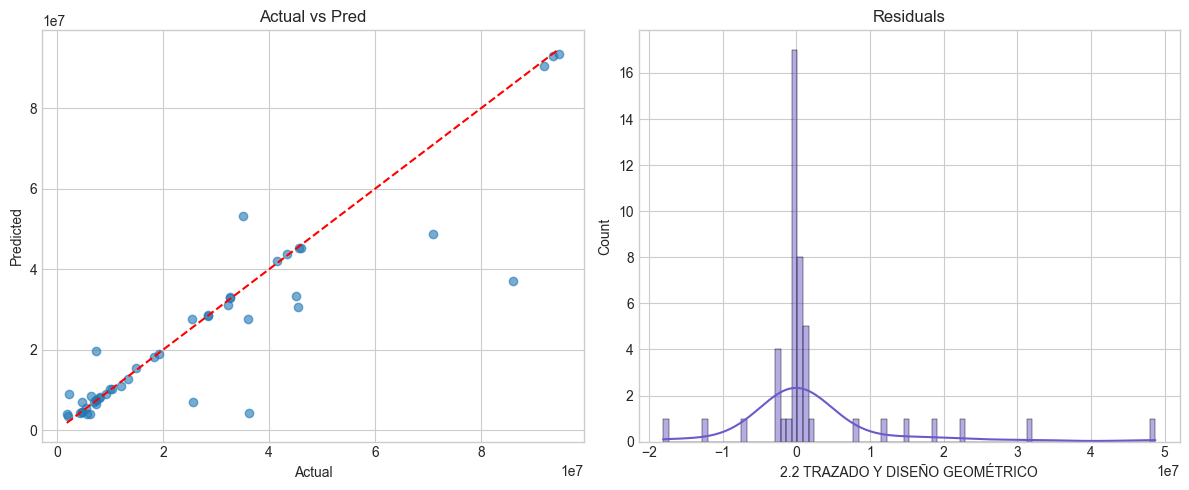

*********2.3 - SEGURIDAD VIAL*********
Best params: {'regressor__svr__C': 10, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 0.1}
{'R2': 0.7021245251545777, 'MAE': 2935117.1434057527, 'RMSE': np.float64(6947145.043995841), 'RMSLE': np.float64(0.663238913319775), 'MAPE%': 33.67902060920097}


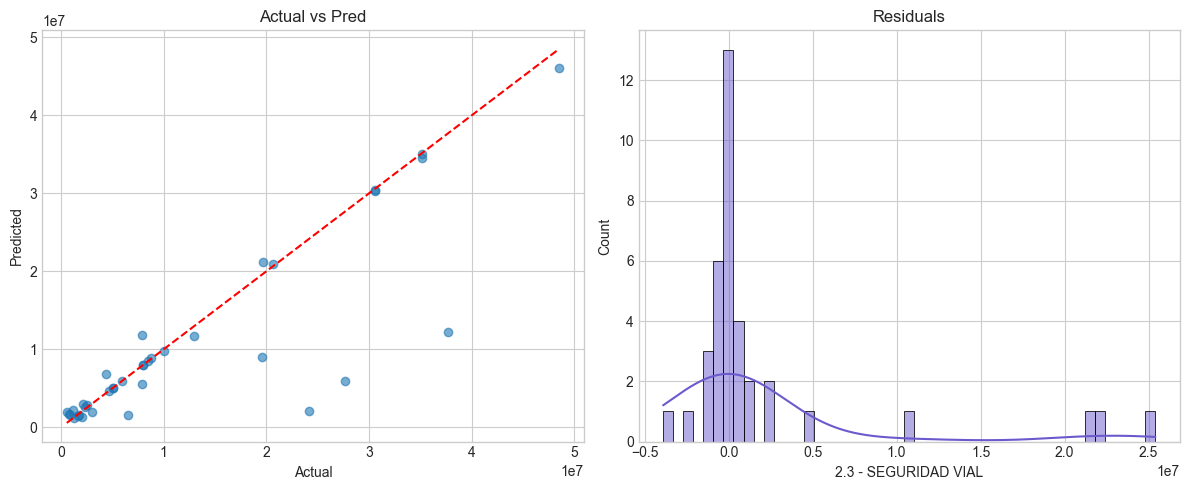

*********2.4 - SISTEMAS INTELIGENTES*********
Best params: {'regressor__svr__C': 1000, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 0.01}
{'R2': 0.6829142232730445, 'MAE': 1491534.1182834106, 'RMSE': np.float64(4312988.809761012), 'RMSLE': np.float64(0.4295724791054236), 'MAPE%': 15.367579069975026}


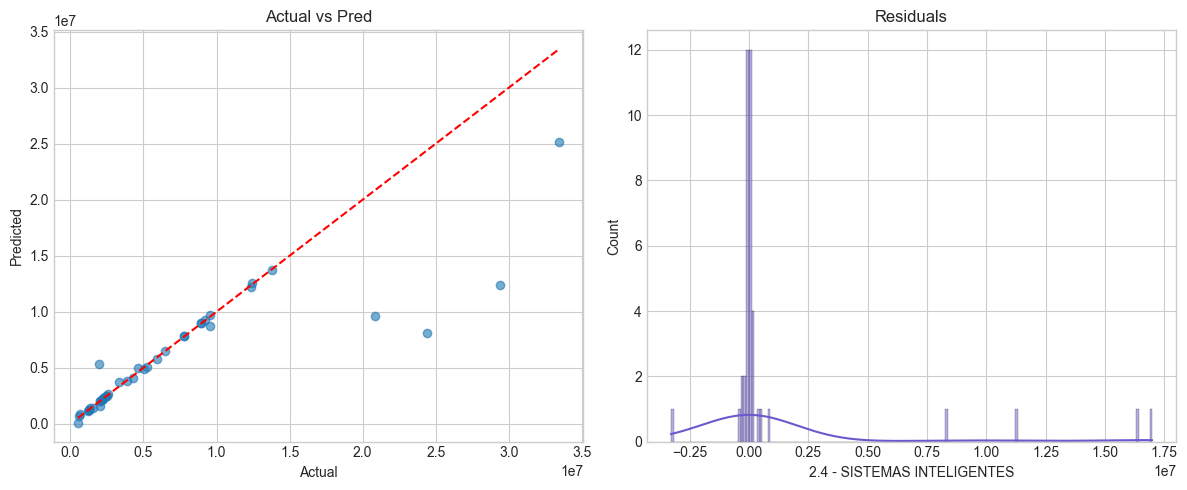

*********5 - TALUDES*********
Best params: {'regressor__svr__C': 200, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 0.01}
{'R2': 0.5340323409843968, 'MAE': 4565893.602043802, 'RMSE': np.float64(14709390.165104842), 'RMSLE': np.float64(0.7327446250503051), 'MAPE%': 13.19015065939804}


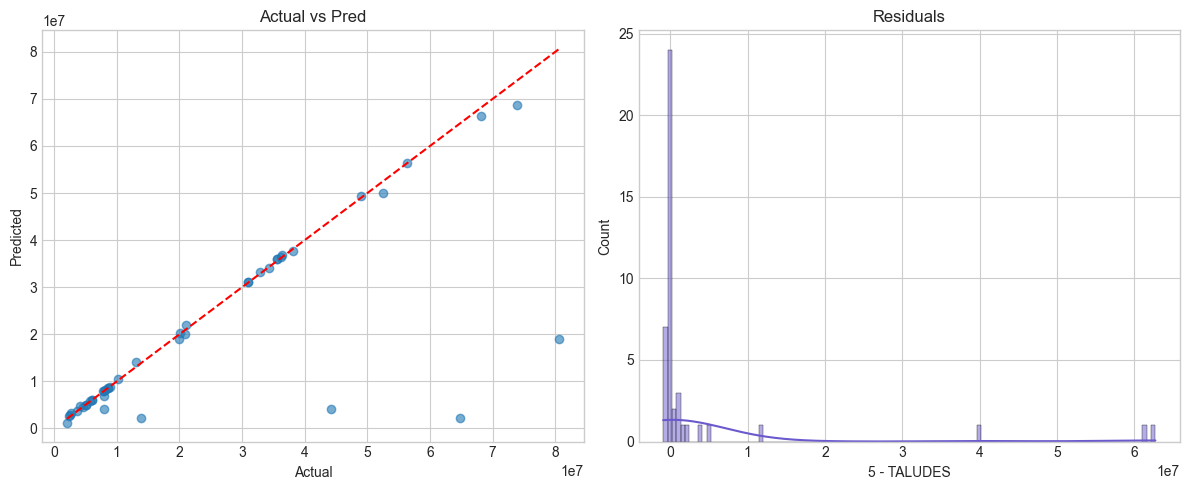

*********6 - PAVIMENTO*********
Best params: {'regressor__svr__C': 80, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 0.01}
{'R2': 0.5141485095331588, 'MAE': 2744377.038573626, 'RMSE': np.float64(6497212.52637507), 'RMSLE': np.float64(0.4150160886656185), 'MAPE%': 26.62643454493983}


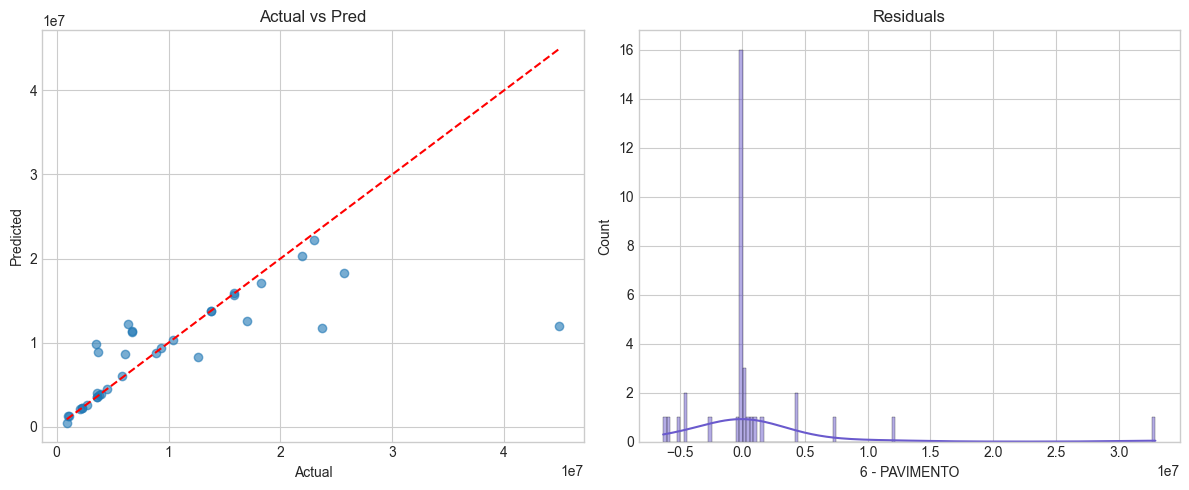

*********7 - SOCAVACIÓN*********
Best params: {'regressor__svr__C': 200, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 0.01}
{'R2': 0.7635739217387287, 'MAE': 6955505.321888966, 'RMSE': np.float64(15628069.985294655), 'RMSLE': np.float64(0.2700263807095928), 'MAPE%': 16.729575017501258}


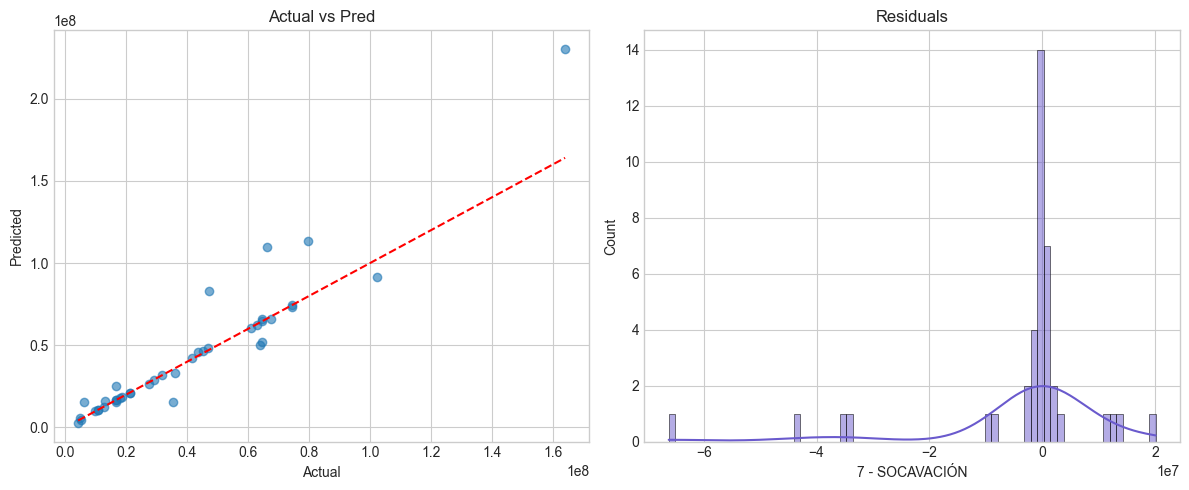

*********11 - PREDIAL*********
Best params: {'regressor__svr__C': 80, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 0.01}
{'R2': 0.9223089972338708, 'MAE': 1885976.294203455, 'RMSE': np.float64(3752901.0136227026), 'RMSLE': np.float64(0.26964411659995785), 'MAPE%': 9.694850506225333}


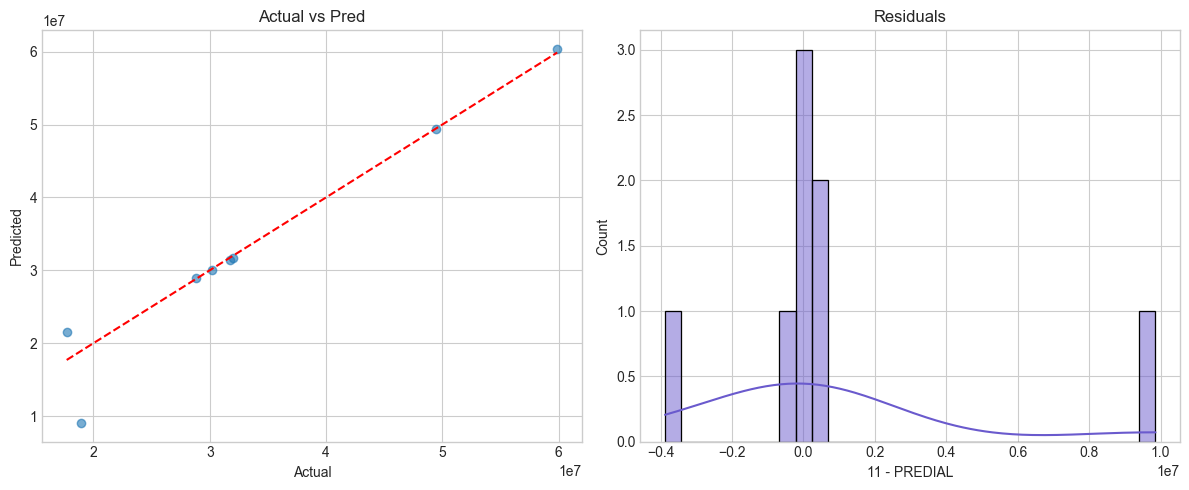

In [14]:
predictor_name = 'LONGITUD KM'
hue_name = 'ALCANCE'
target_names_function_of_longitude = ['2.2 TRAZADO Y DISEÑO GEOMÉTRICO', 
                                      '2.3 - SEGURIDAD VIAL',
                                      '2.4 - SISTEMAS INTELIGENTES', 
                                      '5 - TALUDES',
                                      '6 - PAVIMENTO',
                                      '7 - SOCAVACIÓN',
                                      '11 - PREDIAL',
                                      '12 - IMPACTO AMBIENTAL',
                                      '15 - OTROS - MANEJO DE REDES']

for target_name in target_names_function_of_longitude:
    df_item = df.loc[:, [predictor_name, hue_name, target_name]]
    df_item_cleaned = remove_outliers(df_item, target_name)
    print(f'*********{target_name}*********')
    # preproccesing.show_plots_eda(predictor_name, target_name, hue_name, df_item_cleaned)
    X, y, y_predicted = train_model(df_item_cleaned, predictor_name, hue_name, target_name)
    if target_name == '11 - PREDIAL':
        break
    

In [12]:
X['ACTUAL'] = y
X['PREDICTED'] = y_predicted
output = X.drop(columns=['LONGITUD KM LOG'])
output['difference'] = abs(X['ACTUAL'] - X['PREDICTED'])
output.sort_values(by='difference', ascending=False)

,LONGITUD KM,ALCANCE,ACTUAL,PREDICTED,difference
25,5.243,Mejoramiento,1.891486e+07,9.058283e+06,9.856572e+06
44,14.600,Construcción,1.769477e+07,2.157222e+07,3.877450e+06
45,49.400,Construcción,5.987133e+07,6.036064e+07,4.893080e+05
47,26.400,Construcción,3.199601e+07,3.163653e+07,3.594855e+05
41,26.200,Construcción,3.175362e+07,3.144019e+07,3.134314e+05
43,24.900,Construcción,3.017806e+07,3.003954e+07,1.385193e+05
42,23.800,Construcción,2.884489e+07,2.887359e+07,2.870123e+04
46,40.800,Construcción,4.944838e+07,4.942404e+07,2.434275e+04
